# Retrieve Sites that Surveyors Found Graupel

**Goal**: Plot all the pit locations and identify which pits had graupel and which didn't

**Approach**: 

1. Find all the pits with graupel in the comments.
2. Find all pits without graupel mentioned in the comments
3. Plot them!

## Process

### Step 1. Use the `LayerData` class to find hand hardness profiles that mention graupel

In [1]:
from snowxsql.data import LayerData, SiteData
from snowxsql.db import get_db
from snowxsql.conversions import query_to_geopandas
import geopandas as gpd
import matplotlib.pyplot as plt 

# Connect to the database
db_name = 'snowex'
engine, session = get_db(db_name)

# Build a query looking at hand hardness profiles, 
q_base = session.query(LayerData).filter(LayerData.type == 'hand_hardness')

# add on to the query by filtering on comments containing graupel (case insensitive)
q = q_base.filter(LayerData.comments.contains('graupel'))

# Send query and convert records to a dataframe with the results
df_graupel = query_to_geopandas(q, engine)

print('Sites with Graupel: {}'.format(', '.join(df_graupel['site_id'])))

Sites with Graupel: 4C30, 2C12, 1N5, 9C28, TLSFL2A, 1N7, 5S21, 2S11, 6C34, 1C7, Skyway Open, 2S6, 8N38, 3S47, 8S41, 7S23, County Line Tree, 6S32, FL2A, 1N3, FL1B, 1S12


### Step 2. Use the same query but request the opposite to get pits without graupel

In [2]:
# Use the exact same query except use ~ to ask for the opposite (pits w/o graupel)
q = q_base.filter(~LayerData.comments.contains('graupel'))

# There are multiple layers for a given site at different depths and dates. So insure we don't grab a site that on a given date had graupel
q = q.filter(~LayerData.date.in_(df_graupel['date']), ~LayerData.site_id.in_(df_graupel['site_id']))

# Send query and convert records to a dataframe with the results
df = query_to_geopandas(q, engine)

### Step 3. Plot pits with graupel in color and without in grey 

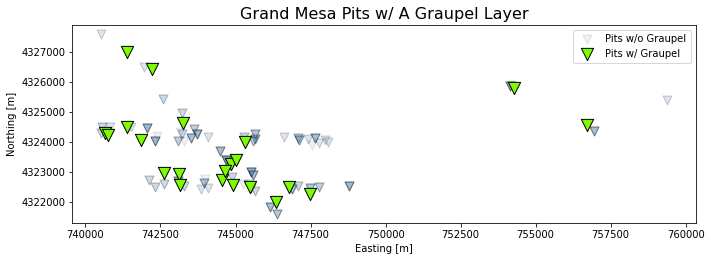

In [3]:
# Close the database session to avoid hanging transactions
session.close()

# Plot the dataframe without graupel as grey and slightly transparent.
ax = df.plot(color='steelblue', alpha=0.1, marker='v', markersize=80, edgecolor='black', label='Pits w/o Graupel', figsize=(10,8))

# Plot the pits with graupel as cyan
ax = df_graupel.plot(color='lawngreen', ax=ax, marker='v', markersize=150, edgecolor='black', label='Pits w/ Graupel')

# Add a legend, x/y labels, and a title, 
ax.legend()
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Grand Mesa Pits w/ A Graupel Layer', FontSize=16)

# Plot labels in plain numbers not scientific notation (default)
ax.ticklabel_format(style='plain', useOffset=False)

# Ask matplotlib to try and avoid overlaying labels on each other
plt.tight_layout()